<a href="https://colab.research.google.com/github/satwik-goyal/CR-CWK/blob/main/CR_CWK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Reshape , Multiply, Activation
from tensorflow.keras.layers import Input, DepthwiseConv2D, GlobalAveragePooling2D , Add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.legacy import RMSprop, Adam
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0



In [9]:
 # Load CIFAR100 dataset
from tensorflow.keras.datasets import cifar100
(X_train, y_train), (X_test, y_test) = cifar100.load_data()

# Normalize pixel values
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# Convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, 100)
y_test = tf.keras.utils.to_categorical(y_test, 100)

In [10]:
print("Shape of the data " , X_train[0].shape)

Shape of the data  (32, 32, 3)


Sample input image: [[[0.98039216 0.98039216 0.972549  ]
  [0.972549   0.9764706  0.9529412 ]
  [0.96862745 0.972549   0.9372549 ]
  ...
  [0.98039216 0.98039216 0.9647059 ]
  [0.98039216 0.98039216 0.9647059 ]
  [0.9764706  0.98039216 0.9647059 ]]

 [[0.98039216 0.9843137  0.9607843 ]
  [0.972549   0.9764706  0.93333334]
  [0.96862745 0.96862745 0.91764706]
  ...
  [0.9843137  0.9843137  0.9490196 ]
  [0.9843137  0.9882353  0.9529412 ]
  [0.98039216 0.9843137  0.9529412 ]]

 [[0.9843137  0.9843137  0.95686275]
  [0.98039216 0.972549   0.92941177]
  [0.98039216 0.9607843  0.9137255 ]
  ...
  [0.98039216 0.9764706  0.93333334]
  [0.98039216 0.9764706  0.9411765 ]
  [0.98039216 0.9764706  0.9490196 ]]

 ...

 [[0.8666667  0.8352941  0.7490196 ]
  [0.8666667  0.80784315 0.6901961 ]
  [0.88235295 0.8117647  0.70980394]
  ...
  [0.78039217 0.6901961  0.5254902 ]
  [0.8117647  0.75686276 0.64705884]
  [0.9137255  0.8980392  0.8862745 ]]

 [[0.88235295 0.8745098  0.8       ]
  [0.8901961  0.8

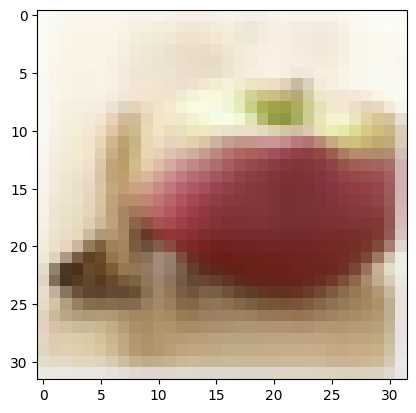

In [11]:
Selected_Image = 2
image = X_train[Selected_Image]
print ("Sample input image: " + str(image))
plt.imshow(image)
plt.show()

In [14]:
def EfficientNet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Base Block
    x = Conv2D(256, (3, 3), padding='same', activation='swish')(inputs)
    x = BatchNormalization()(x)

    # Middle Block (Repeat this block multiple times)
    for _ in range(5):
        x = DepthwiseConv2D((3, 3), padding='same', activation='swish')(x)
        x = BatchNormalization()(x)

        # Squeeze and excitation
        se = GlobalAveragePooling2D()(x)
        se = Reshape((1, 1, int(x.shape[-1])))(se)
        se = Dense(int(x.shape[-1]) // 32, activation='swish')(se)
        se = Dense(int(x.shape[-1]), activation='sigmoid')(se)
        se = Reshape((1, 1, int(x.shape[-1])))(se)
        x = Multiply()([x, se])

        x = Conv2D(128, (1, 1), padding='same', activation='swish')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.2)(x)

    # Top Block
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = tf.keras.Model(inputs, x)

    return model


In [15]:
model = EfficientNet((32,32,3), 100)
model.compile(optimizer = "adam" , loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 32, 32, 256)          7168      ['input_3[0][0]']             
                                                                                                  
 batch_normalization_6 (Bat  (None, 32, 32, 256)          1024      ['conv2d_4[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 depthwise_conv2d_2 (Depthw  (None, 32, 32, 256)          2560      ['batch_normalization_6[0]

In [16]:
model.fit(X_train, y_train, batch_size = 128 , epochs = 20 , validation_split = 0.1)

Epoch 1/20
 15/352 [>.............................] - ETA: 1:07:33 - loss: 4.4905 - accuracy: 0.0354

KeyboardInterrupt: 

In [55]:
history = model.evaluate(X_test ,y_test )

313/313 [==============================] - 5s 15ms/step - loss: 3.9072 - accuracy: 0.2203
